In [ ]:
# centroids generated from this step do not go through the pixel filter!
# but centroids from first half were generated via this step soooooooooooooooooo
# I could generate some centroids from the first half and compare to current values
# looks like I already generated those values
#so why is second half getting flagged? differently
#doesnt explain why there are half differences but does explain the fact the flower is getting picked up p frequ. 
#one filter only saves centroid values for objects with a contour larger than x
#the other filter saves in and out values for 

In [1]:
import time
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
import os, errno
import glob

In [2]:
def erodeimg(image):
    kernel = np.ones((4,4), np.uint8)
    erode = cv2.erode(image, kernel, iterations = 1)
    return erode

In [3]:
def dilateimg(image):
    kernel = np.ones((3,3), np.uint8)
    dilate = cv2.dilate(image, kernel, iterations = 1)
    return dilate

In [4]:
def MotionParameters(image):
    eroded = erodeimg(image)
    dilated = dilateimg(eroded)


    mask = cv2.inRange(dilated, 5, 200)
    kernel = np.ones((10,10), np.uint8)
    close = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    _, contours, hierarchy = cv2.findContours(close, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    area = [cv2.contourArea(c) for c in contours]
    areas = np.asarray(area)
#     areas[areas < 500] = 0
    
    if (len(contours) >= 1) & np.any(areas):
        max_i = np.argmax(areas)
        contour_ = contours[max_i]
        contour_h = cv2.convexHull(contour_)
        
        M = cv2.moments(contour_)
        hM = cv2.moments(contour_h)
        centroid_ = (int(M["m10"]/M["m00"])), (int(M["m01"]/M["m00"]))
        centroid_h = (int(hM["m10"]/hM["m00"])), (int(hM["m01"]/hM["m00"]))
    else:
        contour_ = ()
        contour_h = ()
        centroid_ = (np.nan, np.nan)
        centroid_h = (np.nan, np.nan)
    return contour_, contour_h, centroid_, centroid_h

In [5]:
def VideoPull(back_frame, current_frame, file_name, path):
    video = [(os.path.join(root, file), file[0:-4]) 
        for root, dirs, files in os.walk(path) 
        for file in files 
        if file.endswith(file_name + '.mp4')]
    cam = cv2.VideoCapture(video[0][0])
    cam.set(1,back_frame)
    ret, f = cam.read(1)
    background = cv2.cvtColor(f, cv2.COLOR_BGR2GRAY)
    cam.set(1,current_frame)
    ret, c = cam.read(1)
    current = cv2.cvtColor(c, cv2.COLOR_BGR2GRAY)
    difference = cv2.subtract(current,background)

    return background, current, difference

In [6]:
def FrameSequence(file_name, path):
    video = [(os.path.join(root, file), file[0:-4]) 
        for root, dirs, files in os.walk(path) 
        for file in files 
        if file.endswith(file_name + '.mp4')]
    cam = cv2.VideoCapture(video[0][0])
    cam.set(1,0)
    frame_sequence = list(range(0,int(cam.get(cv2.CAP_PROP_FRAME_COUNT))))

    return frame_sequence

In [7]:
file_truet = r"C:\Users\Daniellab\Desktop\Light_level_videos_second_batch\Data\Step6\AllLight_AllMoths.csv"
location = r'C:\Users\Daniellab\Desktop\Light_level_videos_second_batch\Videos'
outpath = r'C:\Users\Daniellab\Desktop\Light_level_videos_second_batch\Data\Motion_Analysis\First_Last_Centroids'
newer_path = r'C:\Users\Daniellab\Desktop\Light_level_videos_second_batch\Data\Motion_Analysis\First_Last_Centroids\ActuallyAllTrials'
centroid_trouble = r'C:\Users\Daniellab\Desktop\Light_level_videos_second_batch\Data\Centroid Troubleshoot'

In [ ]:
# open data frame with all true trial info
# pull out each video based on a name from a list
# for each name pull out all start and end trials that also have true trials
# choose the start and end frame for the first and last entry
# use those integers to loop through (one loop for first centroid and one for last centroid - seperate cells to generate seperate csv w/o altering the visit type)
#     end_frame: list_start/finish[len(list_start/finish)-1]

In [41]:
dFrame = pd.read_csv(file_truet)
list_videos = dFrame.name[dFrame.name.str.contains('L')].unique()

for name in list_videos:
    i = 0
    In_frame = list(dFrame[(dFrame.name == name) & (dFrame.In_Frame.notnull())].In_Frame)
    
    Out_frame = list(dFrame[(dFrame.name == name) & (dFrame.Out_Frame.notnull())].Out_Frame)
    print(len(In_frame), name)
#     contours = []
#     centroids_x = []
#     centroids_y = []
#     contours_hull = []
#     centroids_hull_x = []
#     centroids_hull_y = []
#     frame_ = []
#     for each in In_frame:
#         if name.startswith('L0.1_c-3_m5'):
#             print("lmao do this later")
#     #         frames = FrameSequence(name, location)
#     #         start_frame = 26846
#     #         end_frame = 31433
#     #         frameNum = frames[start_frame:end_frame]
#         elif name.startswith('L0.1_c-3_m10'):
#             print("Not today Satan")
        
#         elif len(In_frame) > 0:
#             print(name)
#             frames = FrameSequence(name, location)

#             start_frame = In_frame[i]-5
#             end_frame = Out_frame[i]+5
#             frameNum = frames[start_frame:end_frame]

#         for frame in frameNum:
#             back, cur, diff = VideoPull(0,frame, name, location)
#             contour, contour_hull, centroid, centroid_hull = MotionParameters(diff)
#             contours.append(contour)
#             centroids_x.append(centroid[0])
#             centroids_y.append(centroid[1])
#             contours_hull.append(contour_hull)
#             centroids_hull_x.append(centroid_hull[0])
#             centroids_hull_y.append(centroid_hull[1])
#             frame_.append(frame)
#         i+= 1
        
#     new_df = (pd.DataFrame({'FrameNumber' : frame_, 'Name': name, 'X_position' : centroids_hull_x, 
#                                 'Y_position' : centroids_hull_y}))

#     new_df.to_csv(newer_path + "//" + 'Final_position_centroid_method_AllTrial_' + name + '.csv')

3 L0.1_c-3_m12
63 L0.1_c-3_m20
63 L0.1_c-3_m21
20 L0.1_c-3_m22
7 L0.1_c-3_m23
1 L0.1_c-3_m24
2 L0.1_c-3_m25
10 L0.1_c-3_m2
22 L0.1_c-3_m8
22 L0.1_c-3_m32
27 L0.1_c-3_m34
7 L0.1_c-3_m37
14 L0.1_c-3_m38
16 L0.1_c-3_m39
23 L0.1_c-3_m40
28 L0.1_c-3_m41
11 L0.1_c-3_m43
37 L0.1_c-3_m44
38 L0.1_c-3_m5
8 L50_c-3_m10
25 L50_c-3_m12
22 L50_c-3_m13
14 L50_c-3_m14
24 L50_c-3_m15
25 L50_c-3_m21
49 L50_c-3_m22
1 L50_c-3_m24
2 L50_c-3_m2
8 L50_c-3_m6
3 L50_c-3_m30
37 L50_c-3_m32
3 L50_c-3_m33
4 L50_c-3_m34
4 L50_c-3_m35
6 L50_c-3_m37
7 L50_c-3_m38
30 L50_c-3_m39
9 L50_c-3_m45


In [39]:
new_df

,FrameNumber,Name,X_position,Y_position
0,26841,L0.1_c-3_m5,NaN,NaN
1,26842,L0.1_c-3_m5,351.0,461.0
2,26843,L0.1_c-3_m5,NaN,NaN
3,26844,L0.1_c-3_m5,NaN,NaN
4,26845,L0.1_c-3_m5,NaN,NaN
5,26846,L0.1_c-3_m5,367.0,468.0
6,26847,L0.1_c-3_m5,NaN,NaN
7,26848,L0.1_c-3_m5,NaN,NaN
8,26849,L0.1_c-3_m5,NaN,NaN
9,26850,L0.1_c-3_m5,NaN,NaN


In [19]:
dFrame = pd.read_csv(file_truet)
list_videos = dFrame.name[dFrame.name.str.contains('L')].unique()

for name in second_last:

    In_frame = list(dFrame[(dFrame.name == name) & (dFrame.In_Frame.notnull())].In_Frame)
    
    Out_frame = list(dFrame[(dFrame.name == name) & (dFrame.Out_Frame.notnull())].Out_Frame)
    print(len(In_frame), name)
    
    if name.startswith('L0.1_c-3_m5'):
        frames = FrameSequence(name, location)
        start_frame = 26846
        end_frame = 31433
        frameNum = frames[start_frame:end_frame]
    elif len(In_frame) > 0:
        print(name)
        frames = FrameSequence(name, location)
        
        start_frame = In_frame[0]-5
        end_frame = Out_frame[0]+5
        frameNum = frames[start_frame:end_frame]
    contours = []
    centroids_x = []
    centroids_y = []
    contours_hull = []
    centroids_hull_x = []
    centroids_hull_y = []
    frame_ = []

    
    for frame in frameNum:
        back, cur, diff = VideoPull(0,frame, name, location)
        contour, contour_hull, centroid, centroid_hull = MotionParameters(diff)
        contours.append(contour)
        centroids_x.append(centroid[0])
        centroids_y.append(centroid[1])
        contours_hull.append(contour_hull)
        centroids_hull_x.append(centroid_hull[0])
        centroids_hull_y.append(centroid_hull[1])
        frame_.append(frame)

    new_df = (pd.DataFrame({'FrameNumber' : frame_, 'Name': name, 'X_position' : centroids_hull_x, 
                                'Y_position' : centroids_hull_y}))

    new_df.to_csv(outpath + "//" + 'Final_position_centroid_method_FirstTrial_' + name + '.csv')

3 L0.1_c-3_m12
L0.1_c-3_m12
63 L0.1_c-3_m20
L0.1_c-3_m20
63 L0.1_c-3_m21
L0.1_c-3_m21
20 L0.1_c-3_m22
L0.1_c-3_m22
7 L0.1_c-3_m23
L0.1_c-3_m23
1 L0.1_c-3_m24
L0.1_c-3_m24
2 L0.1_c-3_m25
L0.1_c-3_m25
10 L0.1_c-3_m2
L0.1_c-3_m2
22 L0.1_c-3_m8
L0.1_c-3_m8
22 L0.1_c-3_m32
L0.1_c-3_m32
27 L0.1_c-3_m34
L0.1_c-3_m34
7 L0.1_c-3_m37
L0.1_c-3_m37
14 L0.1_c-3_m38
L0.1_c-3_m38
16 L0.1_c-3_m39
L0.1_c-3_m39
23 L0.1_c-3_m40
L0.1_c-3_m40
28 L0.1_c-3_m41
L0.1_c-3_m41
11 L0.1_c-3_m43
L0.1_c-3_m43
37 L0.1_c-3_m44
L0.1_c-3_m44
38 L0.1_c-3_m5
8 L50_c-3_m10
L50_c-3_m10
25 L50_c-3_m12
L50_c-3_m12
22 L50_c-3_m13
L50_c-3_m13
14 L50_c-3_m14
L50_c-3_m14
24 L50_c-3_m15
L50_c-3_m15
25 L50_c-3_m21
L50_c-3_m21
49 L50_c-3_m22
L50_c-3_m22
1 L50_c-3_m24
L50_c-3_m24
2 L50_c-3_m2
L50_c-3_m2
8 L50_c-3_m6
L50_c-3_m6
3 L50_c-3_m30
L50_c-3_m30
37 L50_c-3_m32
L50_c-3_m32
3 L50_c-3_m33
L50_c-3_m33
4 L50_c-3_m34
L50_c-3_m34
4 L50_c-3_m35
L50_c-3_m35
6 L50_c-3_m37
L50_c-3_m37
7 L50_c-3_m38
L50_c-3_m38
30 L50_c-3_m39
L50_c-3_m39


IndexError: list index out of range

In [14]:
dFrame = pd.read_csv(file_truet)
second_last = [('L0.1_c-3_m8', -11), ('L0.1_c-3_m23', -2), ('L0.1_c-3_m41', -12)]
for name in second_last:
    index = name[1]
    name = name[0]
    
    print(index)
    print(name)

-11
L0.1_c-3_m8
-2
L0.1_c-3_m23
-12
L0.1_c-3_m41


In [82]:
dFrame = pd.read_csv(file_truet)
second_last = [('L50_c-3_m45', -1)]
for name in second_last:
    index = name[1]
    name = name[0]
    
    In_frame = list(dFrame[(dFrame.name == name) & (dFrame.In_Frame.notnull())].In_Frame)
    
    Out_frame = list(dFrame[(dFrame.name == name) & (dFrame.Out_Frame.notnull())].Out_Frame)

    if name.startswith('L0.1_c-3_m5'):
        frames = FrameSequence(name, location)
        start_frame = 99777
        end_frame = 100426
        frameNum = frames[start_frame:end_frame]
    elif len(In_frame) > 0:
        print(name)
        frames = FrameSequence(name, location)
        
        start_frame = In_frame[index]+20
        end_frame = Out_frame[index]-20
        frameNum = frames[start_frame:end_frame]
    contours = []
    centroids_x = []
    centroids_y = []
    contours_hull = []
    centroids_hull_x = []
    centroids_hull_y = []
    frame_ = []

    
    for frame in frameNum:

        back, cur, diff = VideoPull(0,frame, name, location)
        contour, contour_hull, centroid, centroid_hull = MotionParameters(diff)
        contours.append(contour)
        centroids_x.append(centroid[0])
        centroids_y.append(centroid[1])
        contours_hull.append(contour_hull)
        centroids_hull_x.append(centroid_hull[0])
        centroids_hull_y.append(centroid_hull[1])
        frame_.append(frame)

#     new_df = (pd.DataFrame({'FrameNumber' : frame_, 'Name': name, 'X_position' : centroids_hull_x, 
#                                 'Y_position' : centroids_hull_y}))
#     second_last_outpath = r"C:\Users\Daniellab\Desktop\Light_level_videos_second_batch\Data\Motion_Analysis\First_Last_Centroids\Second_Last"
#     new_df.to_csv(second_last_outpath + "//" + 'Final_position_centroid_method_Last_SecondTrial_' + name + '.csv')

L50_c-3_m45


In [88]:
gauss = signal.gaussian(3,3)
x_gauss = signal.convolve(centroids_hull_x, gauss, mode='same', method = 'direct') / gauss.sum()
y_gauss = signal.convolve(centroids_hull_y, gauss, mode = 'same', method = 'direct') / gauss.sum()

In [89]:
len(centroids_hull_x), len(x_gauss)

(276, 276)

In [158]:
dF = pd.read_csv(r"C:\Users\Daniellab\Desktop\Light_level_videos_second_batch\Data\Motion_Analysis\First_Last_Centroids\AllTrial_AllMoths.csv")

In [8]:
dFrame = pd.read_csv(file_truet)
list_videos = dFrame.name[dFrame.name.str.contains('L')].unique()
list_videos
# location = r"C:\Users\Daniellab\Desktop\Light_level_videos_second_batch\Videos\Other_videos"

array(['L0.1_c-3_m12', 'L0.1_c-3_m20', 'L0.1_c-3_m21', 'L0.1_c-3_m22',
       'L0.1_c-3_m23', 'L0.1_c-3_m24', 'L0.1_c-3_m25', 'L0.1_c-3_m2',
       'L0.1_c-3_m8', 'L0.1_c-3_m32', 'L0.1_c-3_m34', 'L0.1_c-3_m37',
       'L0.1_c-3_m38', 'L0.1_c-3_m39', 'L0.1_c-3_m40', 'L0.1_c-3_m41',
       'L0.1_c-3_m43', 'L0.1_c-3_m44', 'L0.1_c-3_m5', 'L50_c-3_m10',
       'L50_c-3_m12', 'L50_c-3_m13', 'L50_c-3_m14', 'L50_c-3_m15',
       'L50_c-3_m21', 'L50_c-3_m22', 'L50_c-3_m24', 'L50_c-3_m2',
       'L50_c-3_m6', 'L50_c-3_m30', 'L50_c-3_m32', 'L50_c-3_m33',
       'L50_c-3_m34', 'L50_c-3_m35', 'L50_c-3_m37', 'L50_c-3_m38',
       'L50_c-3_m39', 'L50_c-3_m45'], dtype=object)

L50_c-3_m45
23083
[506.80653272]
23084
[1219.46250547]
23085
[3864.96075896]


C:\Users\Daniellab\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:491: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return x[reverse].conj()
C:\Users\Daniellab\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:251: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  in1zpadded[sc] = in1.copy()


23086
[670.38590489]
23087
[603.07226944]
23088
[1560.37349792]
23089
[2286.49219775]
23090
[2826.01460491]
23091
[665.31928717]
23092
[1490.01989183]
23093
[1448.61838702]
23094
[4003.78608455]
23095
[763.46691047]
23096
[2363.50478713]
23097
[1991.0360043]
23098
[3144.19819786]
23099
[812.97500365]
23100
[2351.4896651]
23101
[2985.25116189]
23102
[1745.95646705]
23103
[1091.20469684]
23104
[2257.25057547]
23105
[3674.89021413]


C:\Users\Daniellab\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


23106
[1253.62598497]
23107
[2296.19115168]
23108
[1492.33605993]
23109
[4274.0539499]
23110
[1116.39302495]
23111
[2736.11833047]
23112
[1419.37676473]
23113
[4419.82777979]
23114
[1073.68867558]
23115
[2311.82528636]
23116
[1609.44730957]
23117
[3578.76923791]
23118
[3209.19566521]
23119
[1869.72669998]
23120
[1332.52046092]
23121
[4726.72005324]


KeyboardInterrupt: 

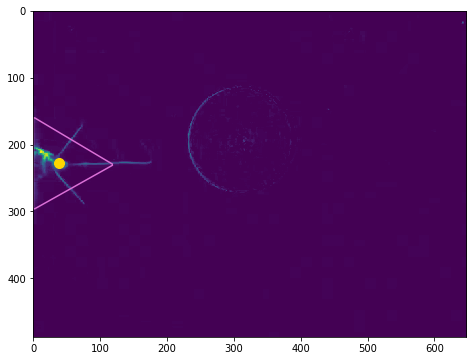

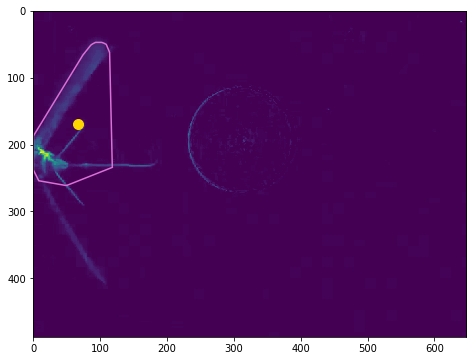

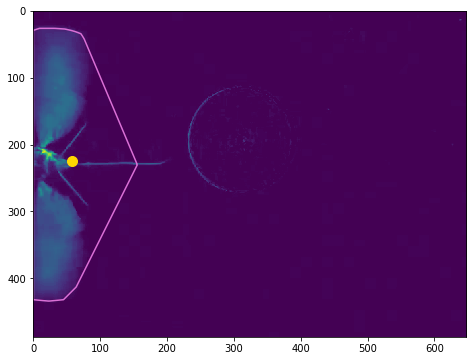

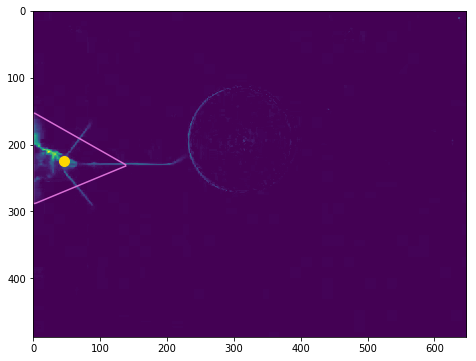

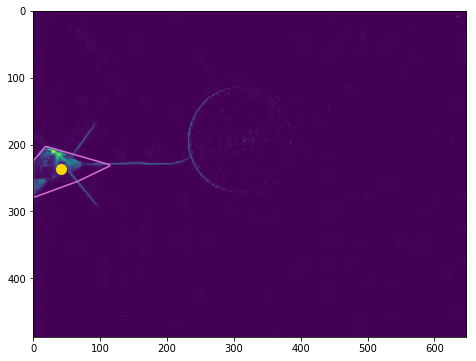

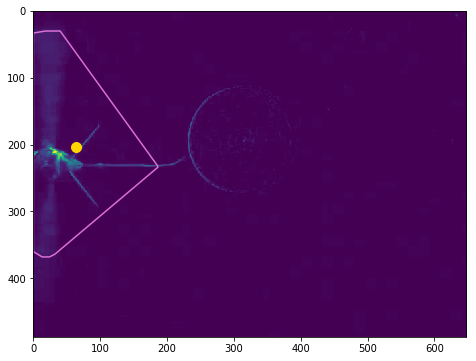

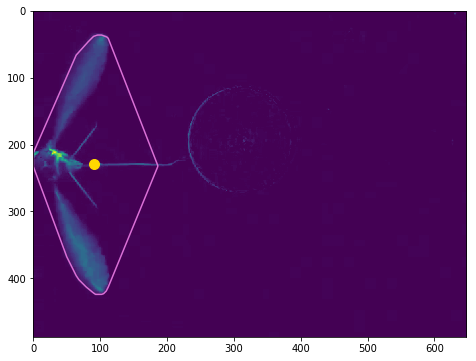

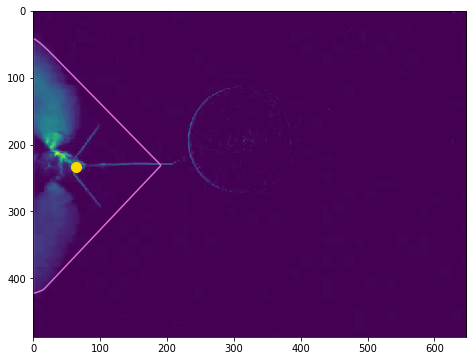

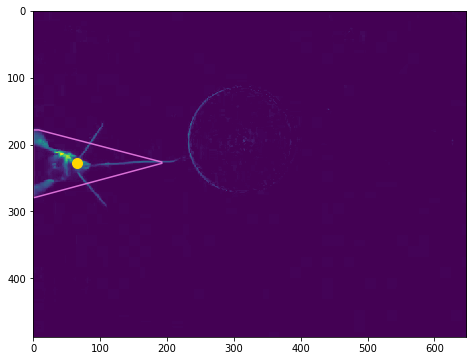

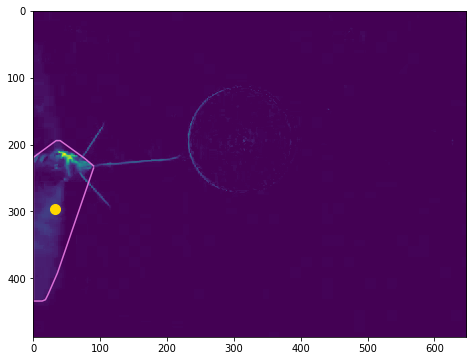

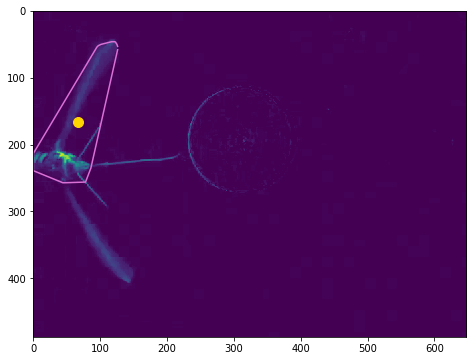

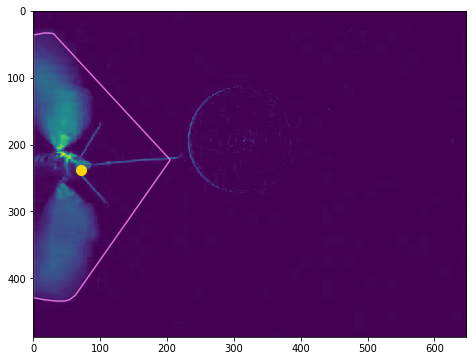

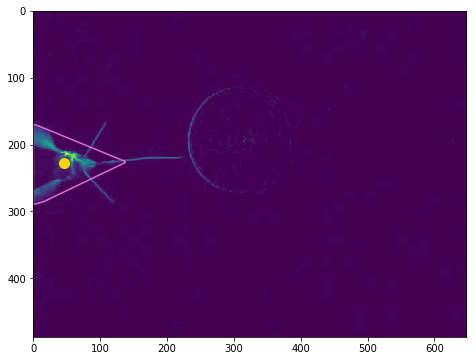

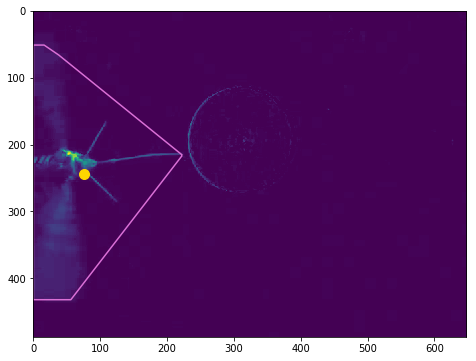

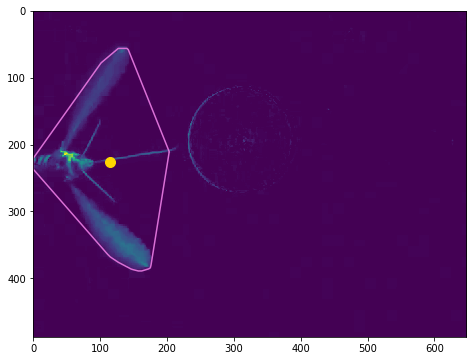

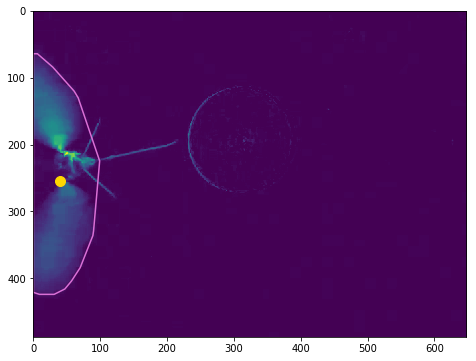

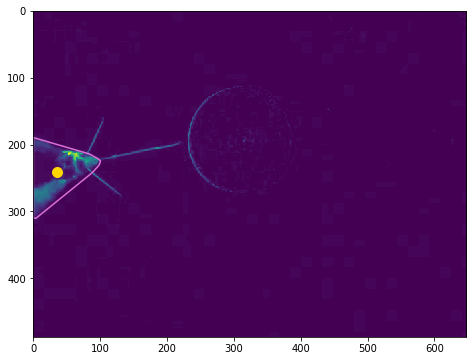

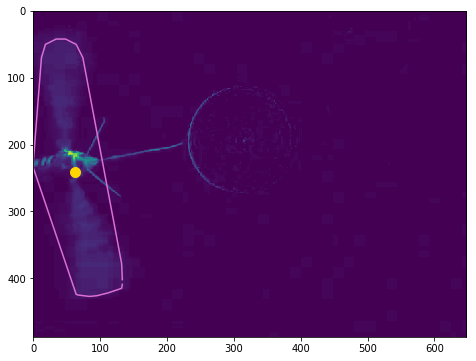

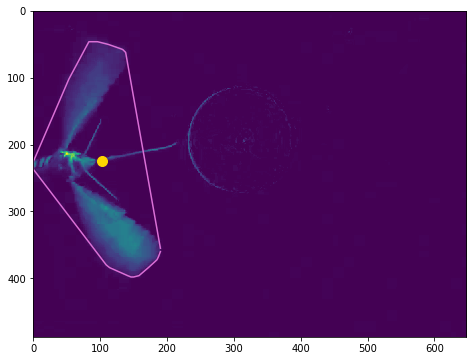

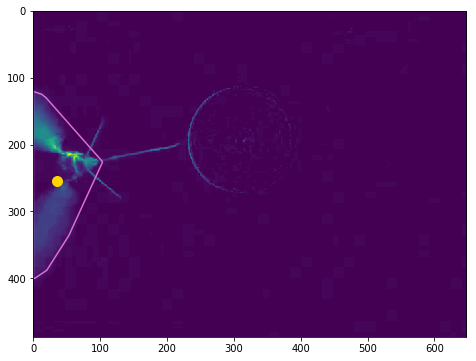

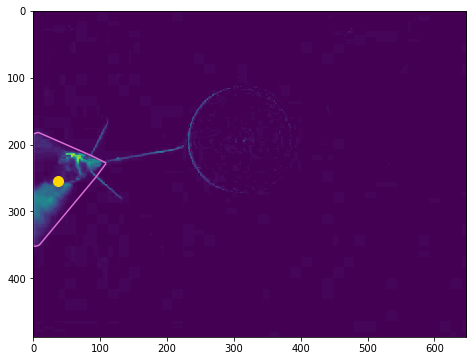

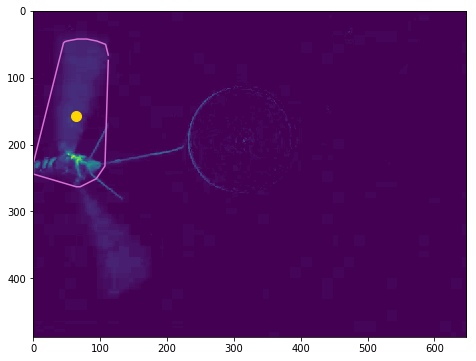

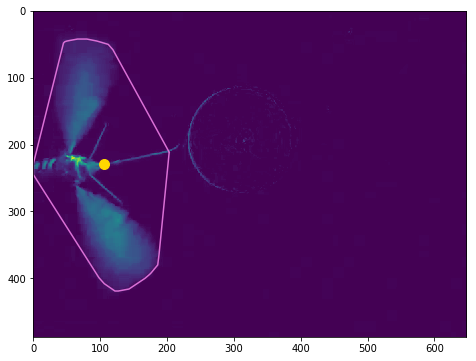

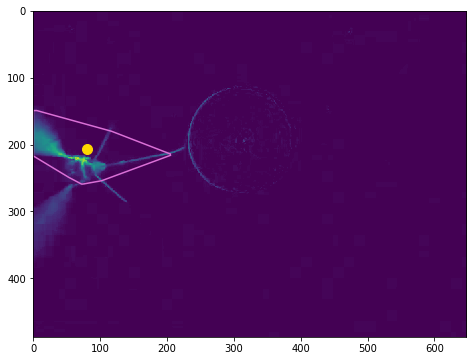

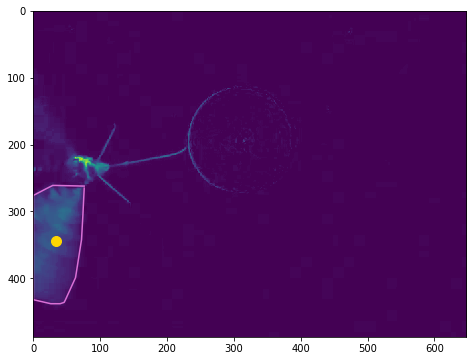

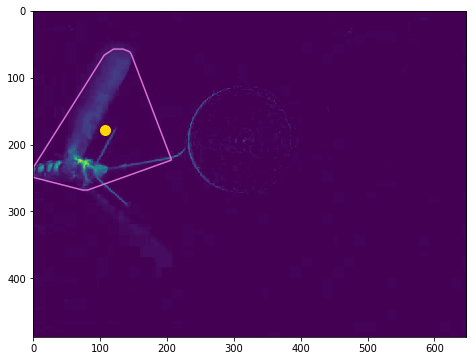

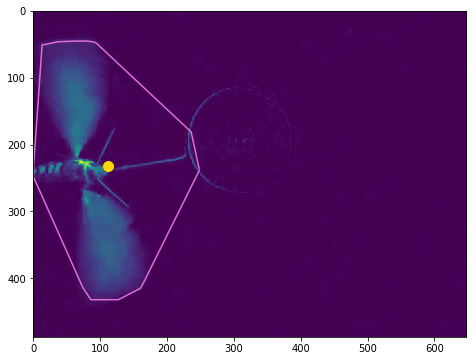

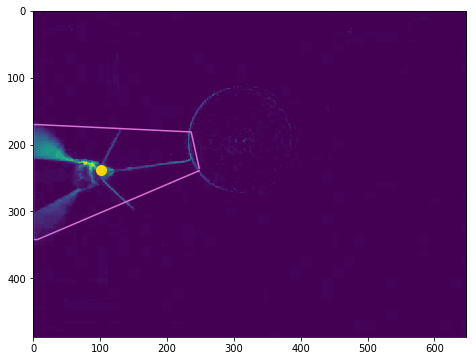

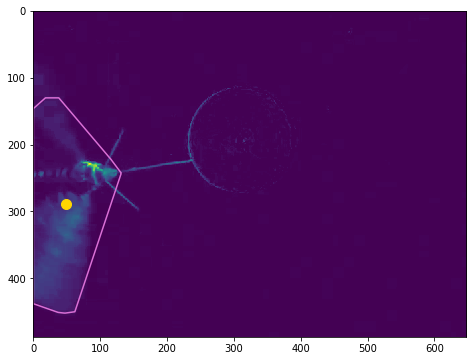

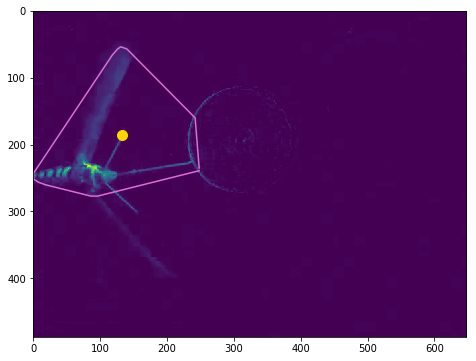

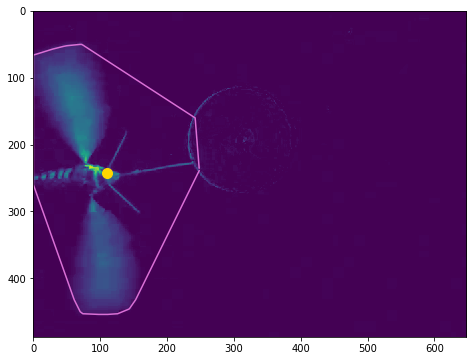

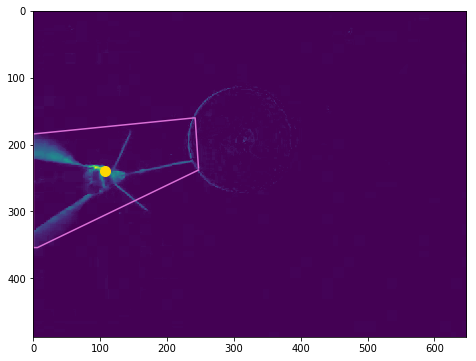

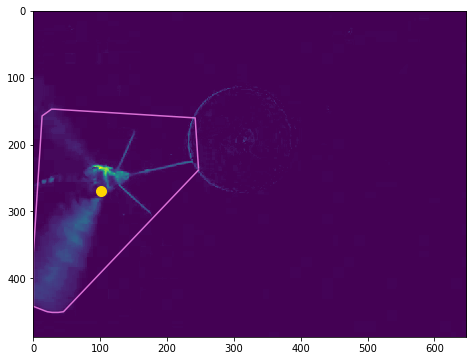

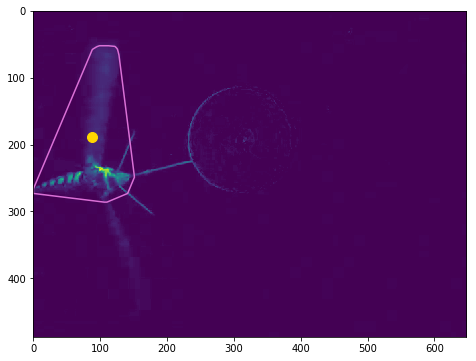

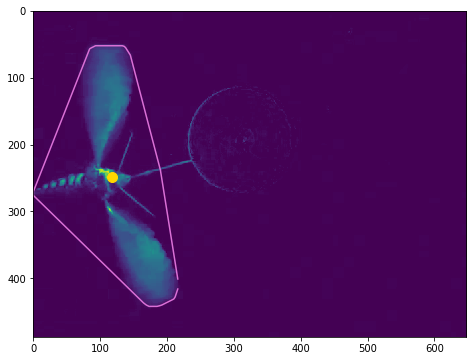

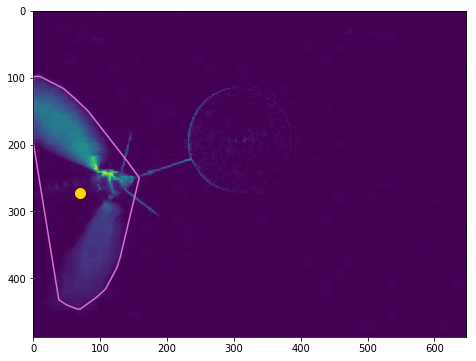

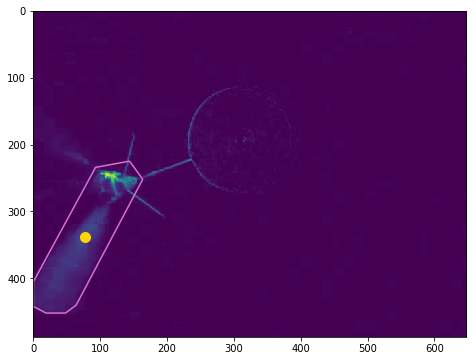

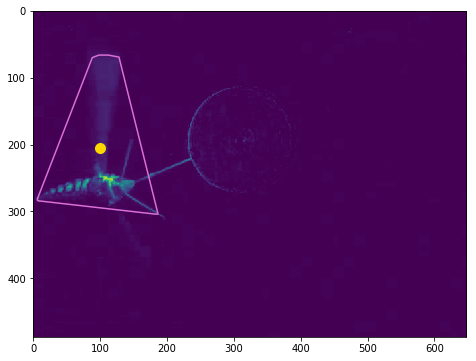

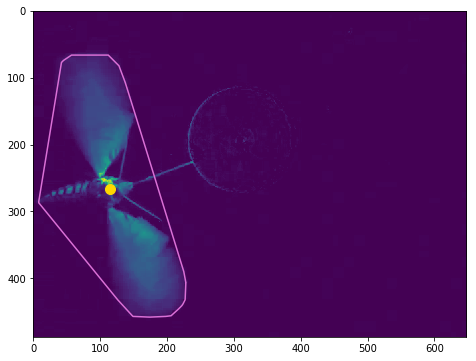

In [14]:
for name in list_videos[-1:]:
    
    In_frame = list(dFrame[(dFrame.name == name) & (dFrame.In_Frame.notnull())].In_Frame)
    
    Out_frame = list(dFrame[(dFrame.name == name) & (dFrame.Out_Frame.notnull())].Out_Frame)

    if name.startswith('L0.1_c-3_m5'):
        frames = FrameSequence(name, location)
        start_frame = 99777
        end_frame = 100426
        frameNum = frames[start_frame:end_frame]
    elif len(In_frame) > 0:
        print(name)
        frames = FrameSequence(name, location)
        
        start_frame = In_frame[0]
        end_frame = Out_frame[0]
        frameNum = frames[start_frame:end_frame]
    try:
        os.makedirs(centroid_trouble + "\\" + name)
    except OSError as e:
        if e.errno != errno.EEXIST:
            raise
    new_folder = centroid_trouble + "\\" + name       
    i = 0        
    for frame in frameNum:
        i+=1
        back, cur, diff = VideoPull(0,frame, name, location)
        a = np.array([pix_count(diff)])
        b = smooth(a)
        contour, contour_hull, centroid, centroid_hull = MotionParameters(diff)
        if len(contour) >= 1:
            
            fig = plt.figure(figsize = (20,6))
            print(frame)
            print(b)
            plt.imshow(diff)
            plt.plot(np.squeeze(contour_hull)[:,0],np.squeeze(contour_hull)[:,1],'orchid')
            plt.plot(centroid_hull[0],centroid_hull[1], 'o', color='gold', markersize = 10)
           
            
        else: 
            plt.imshow(diff)
            



    
            
#         plt.axis('off')
#         plt.savefig(new_folder + '\\' + name + "_" + str(frameNum[i-1]) + '.png')

In [38]:
for name in list_videos[-5:-4]:
    
    In_frame = list(dFrame[(dFrame.name == name) & (dFrame.In_Frame.notnull())].In_Frame)
    
    Out_frame = list(dFrame[(dFrame.name == name) & (dFrame.Out_Frame.notnull())].Out_Frame)

    if name.startswith('L0.1_c-3_m5'):
        frames = FrameSequence(name, location)
        start_frame = 99777
        end_frame = 100426
        frameNum = frames[start_frame:end_frame]
    elif len(In_frame) > 0:
        print(name)
        frames = FrameSequence(name, location)
        
        start_frame = 108348
        end_frame = 115800
        frameNum = frames[start_frame:end_frame]
    try:
        os.makedirs(centroid_trouble + "\\" + name)
    except OSError as e:
        if e.errno != errno.EEXIST:
            raise
    new_folder = centroid_trouble + "\\" + name       
    i = 0  
    
    cent = []
    cont = []
    pix = []
    smooth_per_frame = []
    len_dil_list = []
    for frame in frameNum:
        i+=1
        back, cur, diff = VideoPull(0,frame, name, location)
#         fig,ax = plt.subplots(1,2, figsize = (20,6))
        
        eroded =  erodeimg(diff)
        dilated = dilateimg(eroded)
        len_dil = len(dilated[dilated>0])
        a = np.array([pix_count(dilated)])
        d = smooth(a)
        len_dil_list.append(len_dil)
        smooth_per_frame.append(d)
        contour, contour_hull, centroid, centroid_hull = MotionParameters(diff)
        if not len(contour) >= 1: 
            centroid = (np.nan, np.nan)
            contour = ()
            
        cent.append(centroid)
        cont.append(contour)
        pix.append(a)
#         ax[0].imshow(diff)
#         ax[1].imshow(back)
#         ax[0].plot(np.squeeze(contour_hull)[:,0],np.squeeze(contour_hull)[:,1],'orchid')
#         ax[0].plot(centroid_hull[0],centroid_hull[1], 'o', color='gold', markersize = 10)
           
        
    smooth_list = smooth(np.squeeze(np.asarray(pix)))
    

#     for blah in blah:
#         print(b)
#         plt.imshow(plot)
#         plt.plot(cont and cent)
#     fig = plt.figure(figsize = (20,6))
#     print(frame)

#     plt.imshow(diff)
#     plt.plot(np.squeeze(contour_hull)[:,0],np.squeeze(contour_hull)[:,1],'orchid')
#     plt.plot(centroid_hull[0],centroid_hull[1], 'o', color='gold', markersize = 10)
           

    
            
#         plt.axis('off')
#         plt.savefig(new_folder + '\\' + name + "_" + str(frameNum[i-1]) + '.png')


L50_c-3_m35


In [20]:
frameNum

[108348,
 108349,
 108350,
 108351,
 108352,
 108353,
 108354,
 108355,
 108356,
 108357,
 108358,
 108359,
 108360,
 108361,
 108362,
 108363,
 108364,
 108365,
 108366,
 108367,
 108368,
 108369,
 108370,
 108371,
 108372,
 108373,
 108374,
 108375,
 108376,
 108377,
 108378,
 108379,
 108380,
 108381,
 108382,
 108383,
 108384,
 108385,
 108386,
 108387,
 108388,
 108389]

In [37]:
smooth_list[0], np.squeeze(smooth_per_frame)[23], list(pix[0])[0], len_dil_list[0]

(260.4383983013388, 83.38205165591818, 493, 28273)

In [255]:
dil_above_zero = dilated[dilated>0]
dil_0_5 = dil_above_zero[5 > dil_above_zero]
dil_is_5 = dilated[dilated == 5]
len(dilated)*648, len(dil_above_zero), len(dil_0_5), len(dil_is_5)

(316224, 17377, 17353, 24)

In [195]:
plt.dilated

AttributeError: module 'matplotlib.pyplot' has no attribute 'unique'

In [161]:
list(np.squeeze(pix)), list(np.squeeze(len_dil_list))

([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [488,
  488,
  488,
  488,
  488,
  488,
  488,
  488,
  488,
  488,
  488,
  488,
  488,
  488,
  488,
  488,
  488,
  488,
  488,
  488])

In [162]:
len(pix)

20

In [163]:
cob = list(np.ones(len(pix))*3 + list(np.squeeze(pix)))
smooth(cob)[-1], smooth(np.array([cob[-1]]))

(1.9342815190412408, array([0.43428152]))

In [164]:
mob = list(np.zeros(len(pix))) + list(np.squeeze(pix))
smooth(mob)[-1], smooth(np.array([mob[-1]]))

(0.0, array([0.]))

In [69]:
bob = list(np.squeeze(pix)) + list(np.zeros(len(pix)))
smooth(np.array([bob[935]])), (smooth(bob))[935]

(array([3419.24315992]), 7558.999146582014)

In [42]:
a, pix[-1]

(array([23620]), array([23620]))

In [68]:
diff

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [12]:
name_path = '/Users/Mahad/Documents/GitHub2/ManducaMultiSenseFeeding/Infrared/L50_c-3_m6.mat'


In [ ]:
# appears that the centroid is completely wrong. Need to make it accurate and check if the other data sets are wrong as well
# this could 100% change all the motion data we've collected!!!

In [15]:

image = diff

In [11]:
def pix_count(image):
    image = np.asarray(image)
    real = image[image>5]
    pixels = len(real)
    return pixels
def smooth(pix_num):
    win_gauss = signal.gaussian(10,3)
    smooth_pix_num = signal.convolve(pix_num, win_gauss, mode='same', method = 'direct') / win_gauss.sum()
    return(smooth_pix_num)
def edge_detect(smooth_pix_num):
    cent_value = np.asarray(smooth_pix_num)
    cent_thresh = 500
    motion = (cent_value > cent_thresh)
    value = cent_value[motion]
    return(value)

In [27]:
win_gauss = signal.gaussian(10,3)
win_gauss

array([0.32465247, 0.50633562, 0.70664828, 0.8824969 , 0.98620712,
       0.98620712, 0.8824969 , 0.70664828, 0.50633562, 0.32465247])

In [16]:
a = np.array([pix_count(image)])
b = smooth(a)
c = edge_detect(b)
c

array([4726.72005324])

In [20]:
a, b

(array([32652]), array([4726.72005324]))

In [100]:
eroded = erodeimg(image)
dilated = dilateimg(eroded)


mask = cv2.inRange(dilated, 5, 200)
kernel = np.ones((10,10), np.uint8)
close = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
_, contours, hierarchy = cv2.findContours(close, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
area = [cv2.contourArea(c) for c in contours]
areas = np.asarray(area)
areas[areas < 500] = 0
areas

array([  0. , 555.5,   0. ])

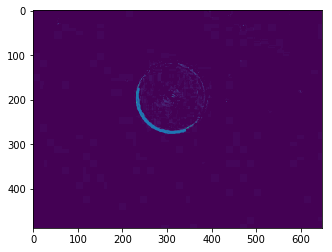

In [115]:
c = contours[1]
plt.imshow(image)
plt.plot(np.squeeze(c)[:,0],np.squeeze(c)[:,1])

In [104]:
len(contours[1])

150

In [109]:
np.squeeze((contours[1])).shape

(150, 2)

In [108]:
contours[1]

array([[[235, 176]],

       [[235, 181]],

       [[234, 182]],

       [[234, 184]],

       [[233, 185]],

       [[233, 193]],

       [[232, 194]],

       [[232, 202]],

       [[233, 203]],

       [[233, 209]],

       [[234, 210]],

       [[234, 216]],

       [[235, 217]],

       [[235, 221]],

       [[237, 223]],

       [[237, 224]],

       [[238, 225]],

       [[238, 226]],

       [[239, 227]],

       [[239, 229]],

       [[240, 230]],

       [[240, 231]],

       [[242, 233]],

       [[242, 235]],

       [[243, 236]],

       [[243, 237]],

       [[246, 240]],

       [[246, 242]],

       [[248, 244]],

       [[249, 244]],

       [[250, 245]],

       [[250, 247]],

       [[254, 251]],

       [[255, 251]],

       [[256, 252]],

       [[256, 253]],

       [[259, 256]],

       [[261, 256]],

       [[262, 257]],

       [[262, 258]],

       [[263, 259]],

       [[264, 259]],

       [[266, 261]],

       [[266, 262]],

       [[267, 262]],

       [[2